In [ ]:
from IPython.display import display, HTML

display(HTML('''
<div style="
    background-color: #f3e8ff;
    padding: 20px;
    border-radius: 12px;
    text-align: center;
">
  <div style="
      font-size: 48px;
      font-weight: bold;
      color: #B266FF;
      text-decoration: underline;
  ">
    Customer Churn Prediction
  </div>
</div>
'''))


### Objective:
The goal of this project is to build a predictive model that identifies customers who are likely to churn based on their service usage patterns and demographics. This helps businesses take proactive retention actions and reduce customer loss.

# Churn_prediction _video_link = https://drive.google.com/file/d/13hGFAk3sxv5tr_lpS7zttwx1-bZMET9k/view?usp=sharing

In [ ]:
!pip install catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split ,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay,ConfusionMatrixDisplay



import warnings
warnings.filterwarnings('ignore')


## 1.Loading Dataset

In [ ]:

# Load data
df_churn = pd.read_csv('Customer_data.csv')

# Preview the data
print("Shape of dataset:", df_churn.shape)

# Summary of data types and nulls
print("\nInfo:")
print(df_churn.info())




Shape of dataset: (7043, 21)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperl

In [ ]:
# Create a summary DataFrame
column_summary = pd.DataFrame({
    'Column': df_churn.columns,
    'Data Type': df_churn.dtypes.values,
    'Unique Values': df_churn.nunique().values
})

# Categorize each column
def classify_column(row):
    if row['Unique Values'] == 2:
        return 'Binary'
    elif row['Data Type'] in ['int64', 'float64']:
        return 'Numerical'
    else:
        return 'Categorical'

column_summary['Category'] = column_summary.apply(classify_column, axis=1)

# Display the summary
column_summary.sort_values(by='Category')


,Column,Data Type,Unique Values,Category
20,Churn,object,2,Binary
1,gender,object,2,Binary
2,SeniorCitizen,int64,2,Binary
3,Partner,object,2,Binary
4,Dependents,object,2,Binary
6,PhoneService,object,2,Binary
16,PaperlessBilling,object,2,Binary
17,PaymentMethod,object,4,Categorical
15,Contract,object,3,Categorical
14,StreamingMovies,object,3,Categorical


## 2.Dropping duplicate rows

In [ ]:
# Check duplicate rows
duplicate_rows = df_churn[df_churn.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [ ]:
# Drop duplicate rows and reset the index
df_churn = df_churn.drop_duplicates().reset_index(drop=True)

# Confirm removal
print(f"New dataset shape: {df_churn.shape}")


New dataset shape: (7043, 21)


## 3.Checking Missing Values

- TotalCharges column consist of 11 null values, we will fill those rows with median


In [ ]:
# Checking missing values
print("\nMissing Values:")
print(df_churn.isnull().sum())


Missing Values:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [ ]:

# Clean 'TotalCharges' which might have missing or space-filled values
df_churn['TotalCharges'] = pd.to_numeric(df_churn['TotalCharges'], errors='coerce')

#filling with median
df_churn['TotalCharges'].fillna(df_churn['TotalCharges'].median(), inplace=True)

In [ ]:
print(df_churn.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## 4. Dropping unwanted column




-Dropping 'customerID' column as it does not bear any information.

In [ ]:
# Drop customerID (not useful for prediction)
df_churn.drop('customerID', axis=1, inplace=True)

## 5.Handling Columns
## 1.Numerical Columns
>  Encoding 'Churn' target column from Yes/No to 1/0


In [ ]:
#To compute correlations involving Churn, we need to convert it to numeric.
df_churn['Churn_encoded'] = df_churn['Churn'].map({'Yes': 1, 'No': 0})


### Correlation of numerical features and target.

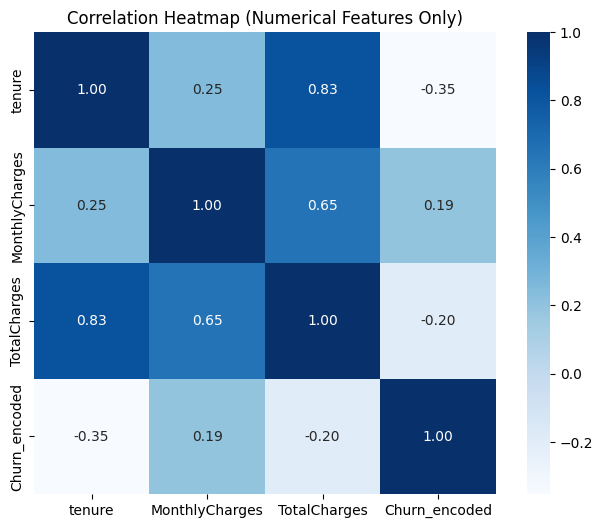

In [ ]:


# Select only numerical columns
numerical_cols = [ 'tenure', 'MonthlyCharges', 'TotalCharges','Churn_encoded']
numerical_data = df_churn[numerical_cols]

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", square=True)
plt.title('Correlation Heatmap (Numerical Features Only)')
plt.show()


 ### Insights
 - tenure and TotalCharges have very strong correlation = 0.83 .This can cause multicollinearity which doesn't affect tree based models (like Random Forest or XGBoost) but will affect Linear models (like Logistic Regression or Linear Regression).
 - Multicollinearity occurs when two or more input features are strongly correlated with each other.Coefficients become unstable and it becomes hard to know which variable is actually influencing the target.
 ### - To solve this issue  we will drop TotalCharges and use it's residual i.e 'TotalCharges_residual' instead  on	all models which will be a balanced, universal fix . <br>
- 'TotalCharges_residual' represents -" How much their payment deviates from expected(based on tenure)."
 ---
 - Step 1: We fit a simple linear model and break down "total charges' as:<br>
<br>
TotalCharges
=
𝑎
⋅
tenure
+
𝑏<br>
<br>
- Step 2: Subtract the predicted values from actual ones:

{TotalCharges_residual} = {Actual TotalCharges} - {Predicted TotalCharges from tenure}<br>

For example:

| tenure | TotalCharges | Predicted | Residual |
| ------ | ------------ | --------- | -------- |
| 10     | 1000         | 1200      | -200     |
| 40     | 3500         | 3200      | +300     |


---
**A positive residual means the person paid more than expected.**<br>
**A negative residual means they paid less than expected.**








| Insight                                       | Action                                                                                                                                                                               |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **`tenure` ↔ `TotalCharges` = 0.83**          |  Create new feature 'Total charges_Residual' |
| **`MonthlyCharges` ↔ `TotalCharges` = 0.65**  |  moderate.                    |
| **`tenure` ↔ `Churn_encoded` = -0.35**        |  Strong negative correlation. **Very important feature.                                                         |
| **`MonthlyCharges` ↔ `Churn_encoded` = 0.19** | Weak but usable.                                                                                                                   |
| **`TotalCharges` ↔ `Churn_encoded` = -0.20**  | Weak but helpful.                                                                                  |


So this new feature 'TotalCharges_residual' will remove multicollinearity with tenure and we  can now use both tenure and TotalCharges_residual without high correlation


In [ ]:
#creating  'TotalCharges_residual' column and dropping TotalCharges


# Step 1: Fit linear model: TotalCharges ~ tenure
lr_temp = LinearRegression()
lr_temp.fit(df_churn[['tenure']], df_churn['TotalCharges'])

# Step 2: Create residual column
df_churn['TotalCharges_residual'] = df_churn['TotalCharges'] - lr_temp.predict(df_churn[['tenure']])

# Step 3: Drop original TotalCharges
df_churn.drop(columns=['TotalCharges'], inplace=True)
df_churn['TotalCharges_residual']

,TotalCharges_residual
0,136.456296
1,-516.433721
2,138.618720
3,-1402.697061
4,182.118720
...,...
7038,345.942041
7039,2063.738380
7040,-308.319467
7041,184.793567


### Numerical columns visualization and outliers handling

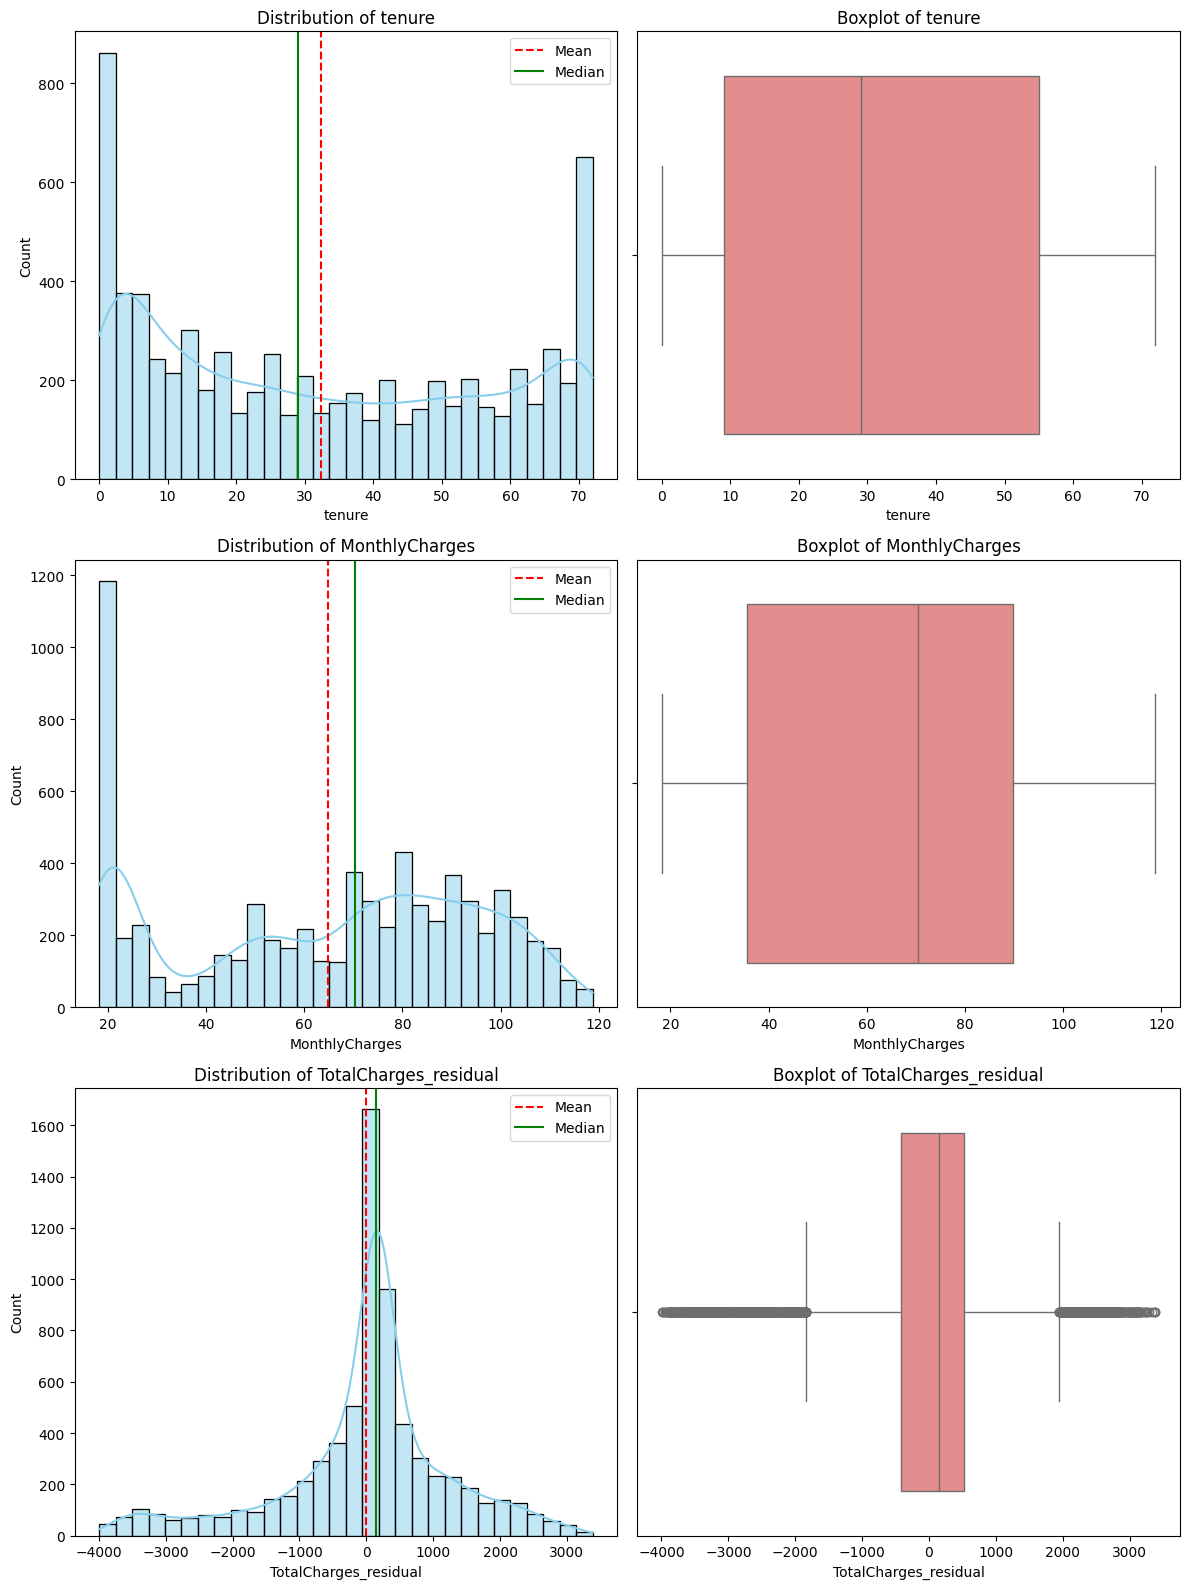

In [ ]:

# Numerical columns
num_cols = [ 'tenure', 'MonthlyCharges', 'TotalCharges_residual']

# Set up the figure
plt.figure(figsize=(12, 16))

for i, col in enumerate(num_cols):
    # Histogram + KDE + mean/median
    plt.subplot(len(num_cols), 2, 2*i + 1)
    sns.histplot(df_churn[col], kde=True, bins=30, color='skyblue')
    plt.axvline(df_churn[col].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(df_churn[col].median(), color='green', linestyle='-', label='Median')
    plt.title(f'Distribution of {col}')
    plt.legend()

    # Boxplot
    plt.subplot(len(num_cols), 2, 2*i + 2)
    sns.boxplot(x=df_churn[col], color='lightcoral')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


## Insights

 1. **tenure**
>Distribution: Left-skewed (more customers with low tenure).<br>
>Boxplot: No extreme outliers. Spread looks reasonable.<br>
>Action:No capping needed but we wil create 'tenure buckets' (New, Mid, Loyal) as new feature (not replacement)	which will help tree models find better splits and help interpretation.

2. **MonthlyCharges**
>Distribution: Fairly normal with mild right skew.<br>
>Boxplot: Slight outliers on the higher end.<br>
>Action:No treatment needed.<br>

3. **TotalCharges**
>Distribution: Perfectly centered around 0,Symmetric, has natural spread.<br>
>Boxplot: Symmetric, some outliers but normal for residuals.<br>
>Action : No action needed , we can use it directly.

### We are creating a new categorical feature called *tenure_bucket* which is  a categorical version of tenure.  This is not a replacement for the original tenure feature, but rather an additional derived feature to enhance model performance and interpretability.

| Bucket  | Tenure Range (months) |
| ------- | --------------------- |
| `New`   | 0–12                  |
| `Mid`   | 12–36                 |
| `Loyal` | >36                   |



In [ ]:
# Create tenure bucket column
def bucket_tenure(t):
    if t < 12:
        return 'New'
    elif t < 36:
        return 'Mid'
    else:
        return 'Loyal'

df_churn['tenure_bucket'] = df_churn['tenure'].apply(bucket_tenure)





In [ ]:
df_churn['tenure_bucket']

,tenure_bucket
0,New
1,Mid
2,New
3,Loyal
4,New
...,...
7038,Mid
7039,Loyal
7040,New
7041,New


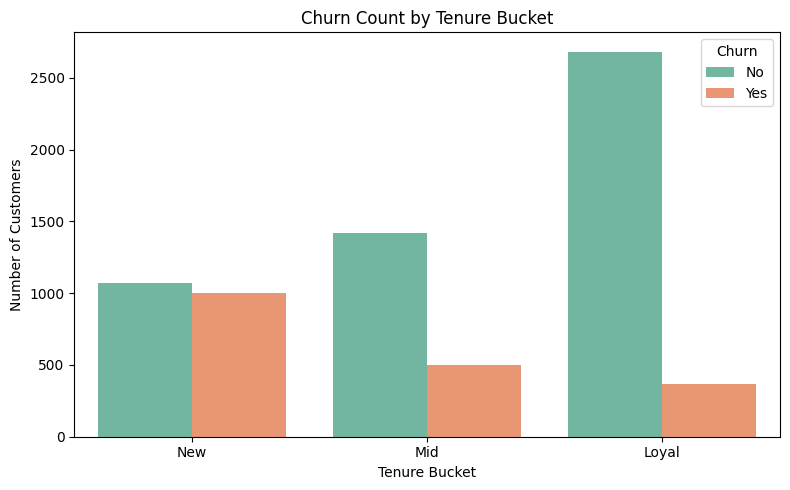

In [ ]:

plt.figure(figsize=(8,5))
sns.countplot(data=df_churn, x='tenure_bucket', hue='Churn_encoded', palette='Set2')
plt.title('Churn Count by Tenure Bucket')
plt.xlabel('Tenure Bucket')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


## Insights
1. New Customers (Tenure < 12 months):
>Churners (Yes) ≈ Non-Churners (No) .<br>
>For New Customers churn risk is Very High so we should Focus retention strategies here.<br>
>High churn rate in this group — about half of new customers are leaving early.<br>

2. Mid Customers (12–36 months):
>Churn rate drops significantly.<br>
>Fewer churners compared to non-churners.<br>
>Suggests increased loyalty after first year.<br>

3. Loyal Customers (>36 months):
>Majority are non-churners.<br>
>Very few churners in this group.<br>
>Strong evidence of retention increasing with time.



---

Numerical columns are all set to get trained

---

## 2.Catagorical columns


In [ ]:

# Select categorical columns
cat_columns = df_churn.select_dtypes(include='object').columns.tolist()

# Create a summary table
cat_summary = pd.DataFrame({
    'Column': cat_columns,
    'Unique Values': [df_churn[col].nunique() for col in cat_columns],
    'Categories': [df_churn[col].unique().tolist() for col in cat_columns]
})

# Display the table
cat_summary



,Column,Unique Values,Categories
0,gender,2,"[Female, Male]"
1,Partner,2,"[Yes, No]"
2,Dependents,2,"[No, Yes]"
3,PhoneService,2,"[No, Yes]"
4,MultipleLines,3,"[No phone service, No, Yes]"
5,InternetService,3,"[DSL, Fiber optic, No]"
6,OnlineSecurity,3,"[No, Yes, No internet service]"
7,OnlineBackup,3,"[Yes, No, No internet service]"
8,DeviceProtection,3,"[No, Yes, No internet service]"
9,TechSupport,3,"[No, Yes, No internet service]"


### Catagorical Column visualization


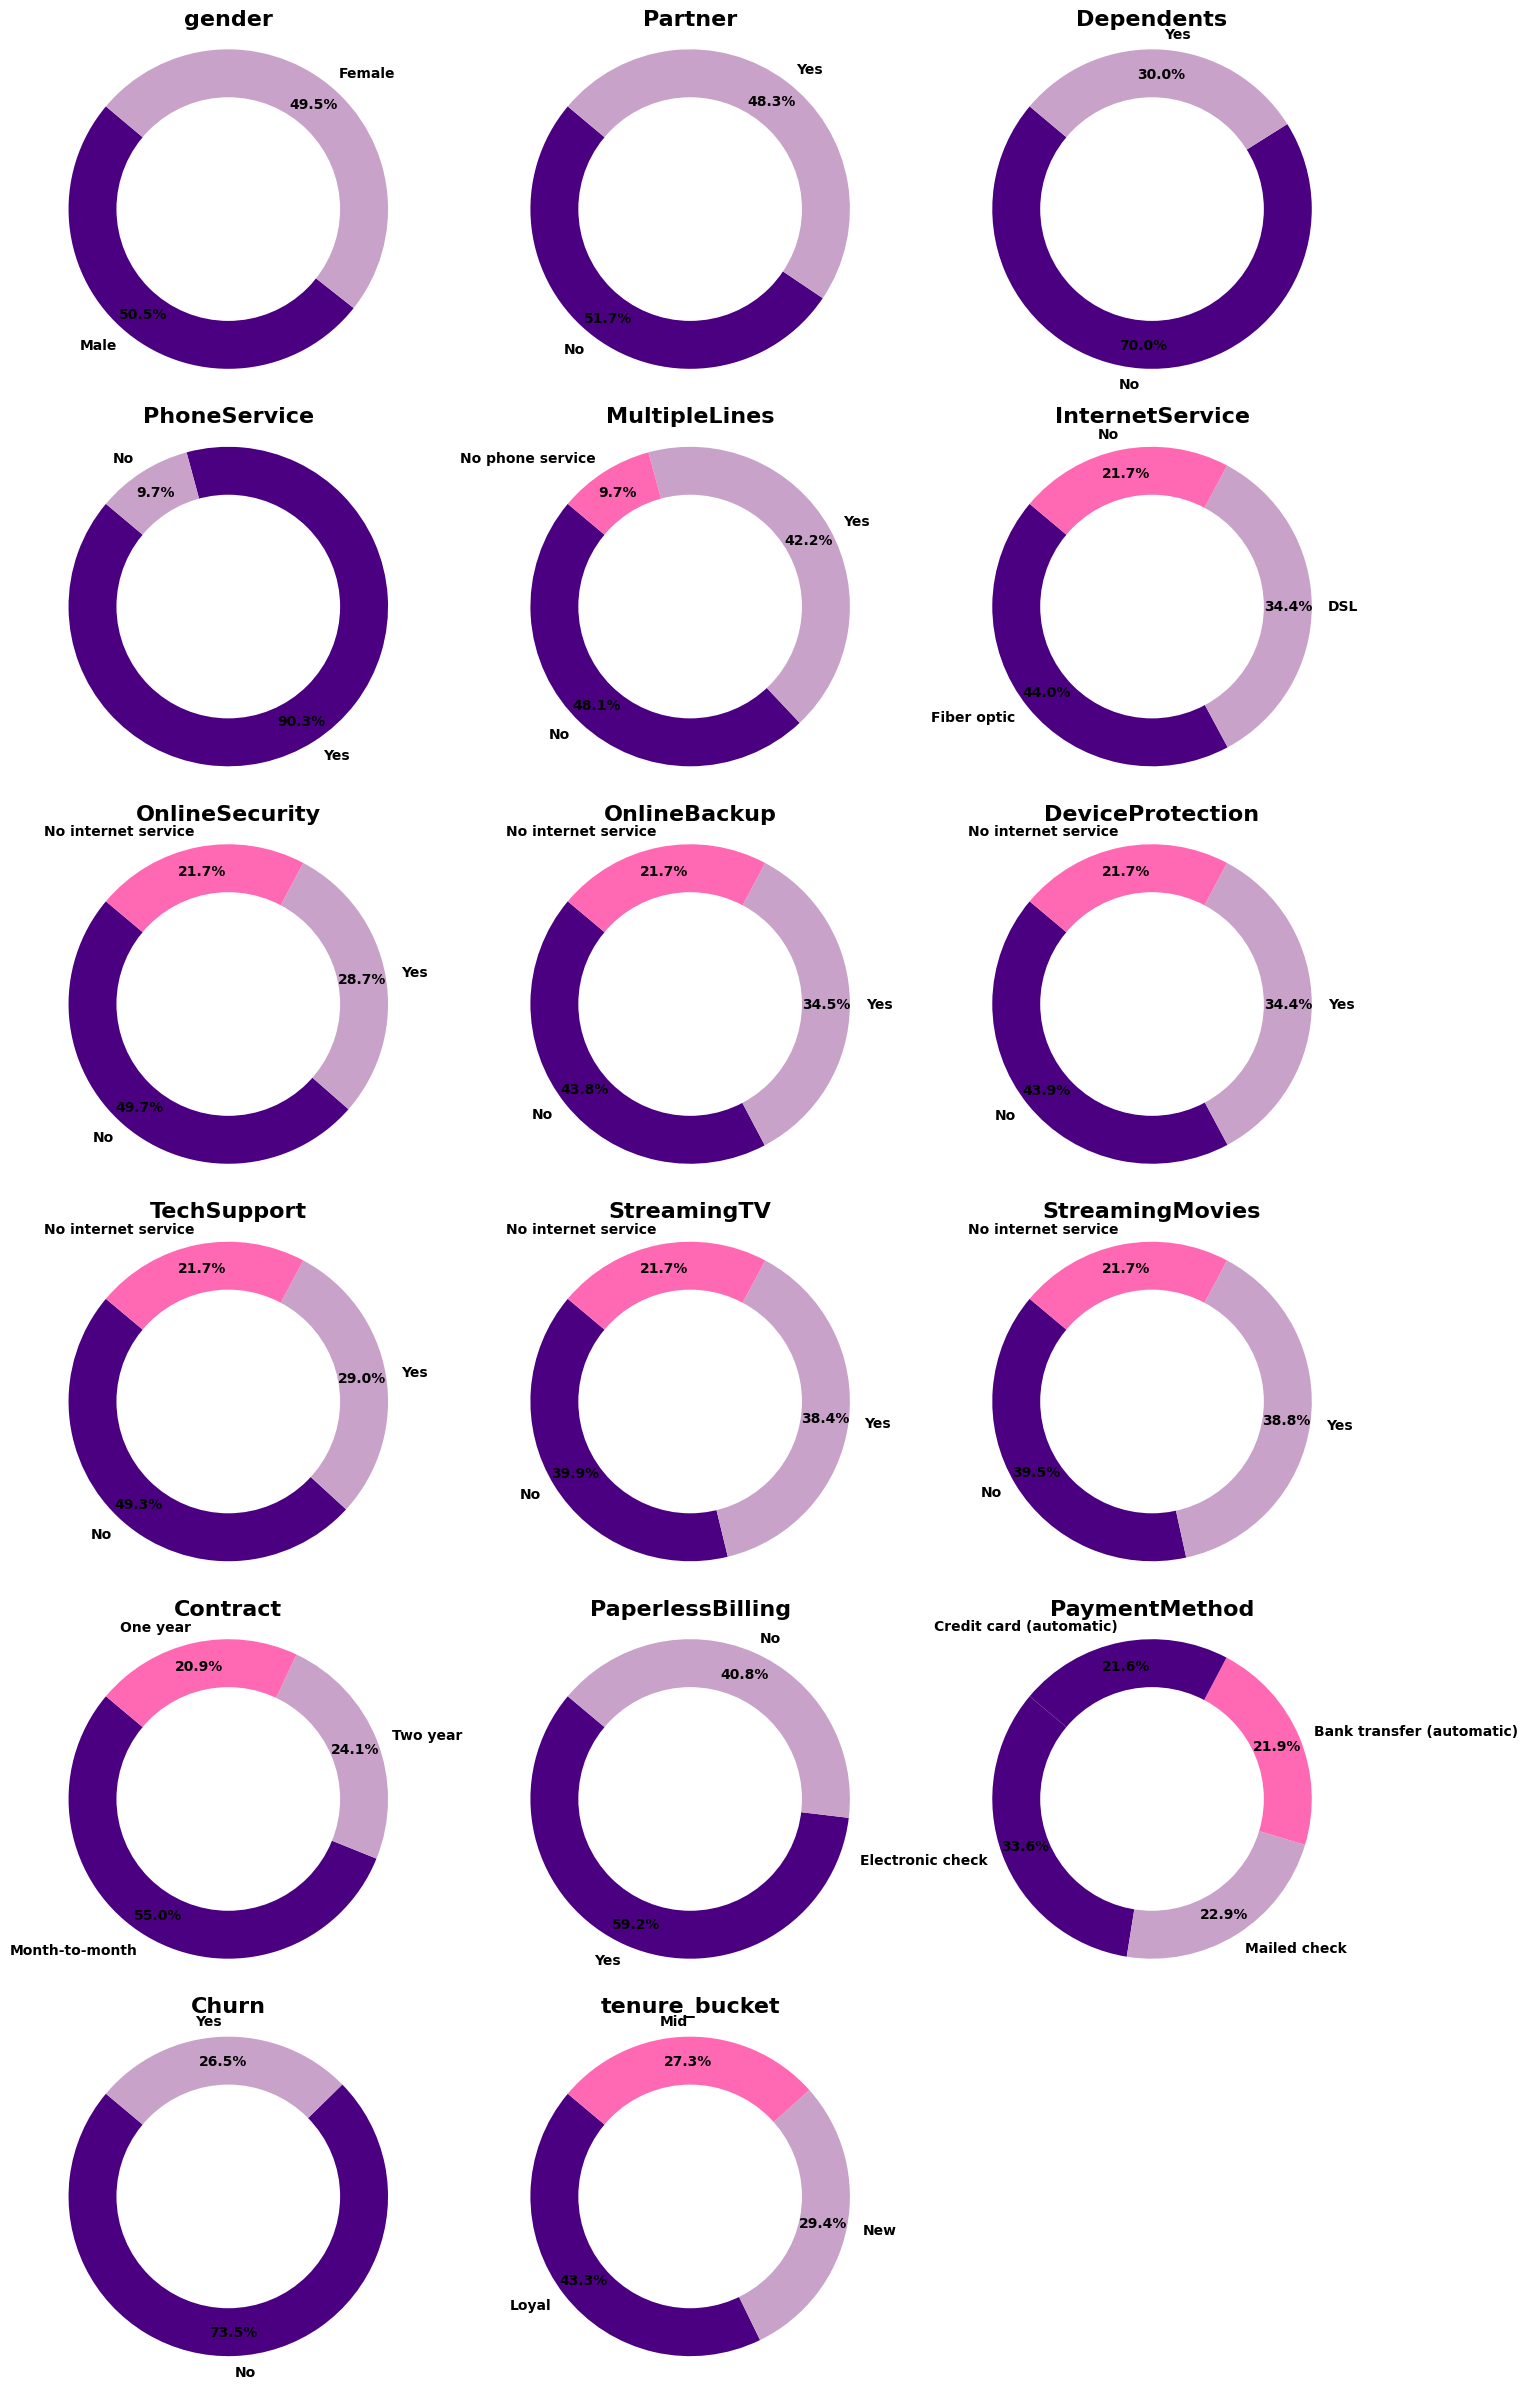

In [ ]:

# Custom color palette
custom_colors = ['#4B0082', '#C8A2C8', '#FF69B4']

n_cols = 3
n_rows = -(-len(cat_columns) // n_cols)  # Ceiling division

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, col in enumerate(cat_columns, 1):
    plt.subplot(n_rows, n_cols, idx)
    values = df_churn[col].value_counts()
    labels = values.index
    sizes = values.values

    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        pctdistance=0.85,
        colors=custom_colors[:len(labels)]
    )

    # Bold text labels and percentages
    for text in texts:
        text.set_fontweight('bold')
    for autotext in autotexts:
        autotext.set_fontweight('bold')

    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    plt.gca().add_artist(centre_circle)

    plt.axis('equal')
    plt.title(f"{col}", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


## Catagorical encoding


In [ ]:


# Make a copy to work on
df_encoded = df_churn.copy()

# Step 1: Binary encoding for Yes/No and gender columns
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
df_encoded[binary_cols] = df_encoded[binary_cols].replace({'Yes': 1, 'No': 0})
df_encoded['gender'] = df_encoded['gender'].replace({'Male': 1, 'Female': 0})

# Step 2: One-hot encoding for all other categorical columns
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'Contract', 'PaymentMethod','tenure_bucket']

# One-hot encode and drop first to avoid multicollinearity
df_encoded = pd.get_dummies(df_encoded, columns=multi_cat_cols, drop_first=True)


# Bools to 1 or 0 # Convert all bool columns to int (0/1)
df_encoded = df_encoded.astype({col: 'int' for col in df_encoded.select_dtypes('bool').columns})


# Final check
print(df_encoded.shape)
df_encoded.head()



(7043, 34)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn,Churn_encoded,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_bucket_Mid,tenure_bucket_New
0,0,0,1,0,1,0,1,29.85,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,0,0,0,34,1,0,56.95,0,0,...,0,0,0,1,0,0,0,1,1,0
2,1,0,0,0,2,1,1,53.85,1,1,...,0,0,0,0,0,0,0,1,0,1
3,1,0,0,0,45,0,0,42.30,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,2,1,1,70.70,1,1,...,0,0,0,0,0,0,1,0,0,1


# 6.Cleaned data


In [ ]:
# Display first few rows of the final dataset
print("Final cleaned & encoded dataset preview:")
display(df_encoded.head())

# Check the shape and info
print(f"\nShape of dataset: {df_encoded.shape}")
print("\nData types:")
print(df_encoded.dtypes)


Final cleaned & encoded dataset preview:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn,Churn_encoded,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_bucket_Mid,tenure_bucket_New
0,0,0,1,0,1,0,1,29.85,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,0,0,0,34,1,0,56.95,0,0,...,0,0,0,1,0,0,0,1,1,0
2,1,0,0,0,2,1,1,53.85,1,1,...,0,0,0,0,0,0,0,1,0,1
3,1,0,0,0,45,0,0,42.30,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,2,1,1,70.70,1,1,...,0,0,0,0,0,0,1,0,0,1



Shape of dataset: (7043, 34)

Data types:
gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
PaperlessBilling                           int64
MonthlyCharges                           float64
Churn                                      int64
Churn_encoded                              int64
TotalCharges_residual                    float64
MultipleLines_No phone service             int64
MultipleLines_Yes                          int64
InternetService_Fiber optic                int64
InternetService_No                         int64
OnlineSecurity_No internet service         int64
OnlineSecurity_Yes                         int64
OnlineBackup_No internet service           int64
OnlineBackup_Yes                           int64
DeviceProtection_No intern

## 7. Handling Target Column

- The target column 'Churn" is highly imbalance.
- This can lead to High accuracy, but poor recall for the minority class (churned customers)
- Models will ignore minority class predictions

## To solve this problem we will apply SMOTE process while training the data.

In [ ]:
round(df_encoded['Churn'].value_counts(normalize=True) * 100,2)

,proportion
Churn,
0,73.46
1,26.54


---
---

# 8. Roadmap of training the model.
>1. SMOTE + Train-Test Split
>2. Initial Model Comparison (Baseline)
>3. Hyperparameter Tuning for Top Models
>4. Final Model Evaluation (Best Tuned Model on Test Set)
>5. Conclusion and Recommendations
>6. Top 20 features from best models

---
---

In [ ]:

# 1. Define target and features
X = df_encoded.drop(['Churn','Churn_encoded'], axis=1)  # drop original target
y = df_encoded['Churn']

# 2. Split before SMOTE (important!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 1. Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

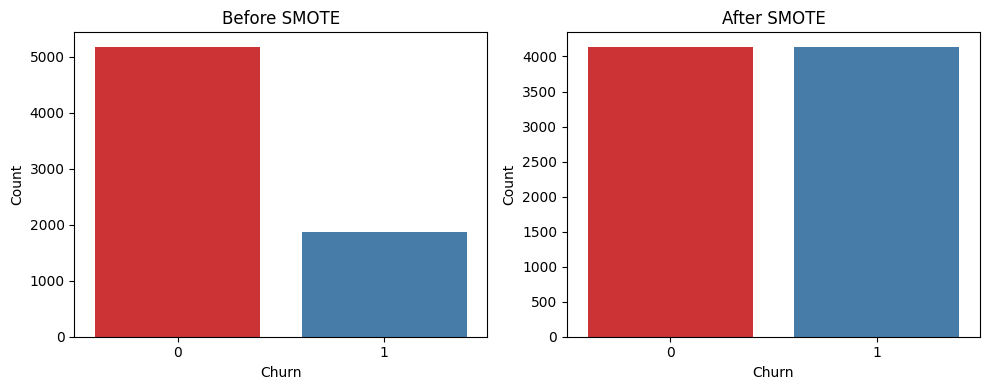

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Before SMOTE
sns.countplot(x=y, ax=ax[0], palette="Set1")
ax[0].set_title("Before SMOTE")
ax[0].set_xlabel("Churn")
ax[0].set_ylabel("Count")

# After SMOTE
sns.countplot(x=y_resampled, ax=ax[1], palette="Set1")
ax[1].set_title("After SMOTE")
ax[1].set_xlabel("Churn")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [ ]:
# Baseline model

# 1. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# 2. Scale data for Logistic Regression only
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# 3. Train & evaluate
results = []

for name, model in models.items():
    if name == "Logistic Regression":
        model.fit(X_resampled_scaled, y_resampled)
        y_pred = model.predict(X_test_scaled)
    else:
        # Convert DataFrames to NumPy arrays for models like XGBoost
        X_resampled_np = X_resampled.values if isinstance(X_resampled, pd.DataFrame) else X_resampled
        X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

        model.fit(X_resampled_np, y_resampled)
        y_pred = model.predict(X_test_np)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (Churn)": precision_score(y_test, y_pred),
        "Recall (Churn)": recall_score(y_test, y_pred),
        "F1-Score (Churn)": f1_score(y_test, y_pred)
    })

# 4. Show results
results_df = pd.DataFrame(results).sort_values(by="F1-Score (Churn)", ascending=False)
print(results_df)

                 Model  Accuracy  Precision (Churn)  Recall (Churn)  \
2    Gradient Boosting  0.775018           0.557613        0.726542   
0  Logistic Regression  0.779986           0.571429        0.675603   
4             CatBoost  0.783534           0.580952        0.654155   
3              XGBoost  0.787083           0.595801        0.608579   
1        Random Forest  0.775727           0.574413        0.589812   

   F1-Score (Churn)  
2          0.630966  
0          0.619165  
4          0.615385  
3          0.602122  
1          0.582011  


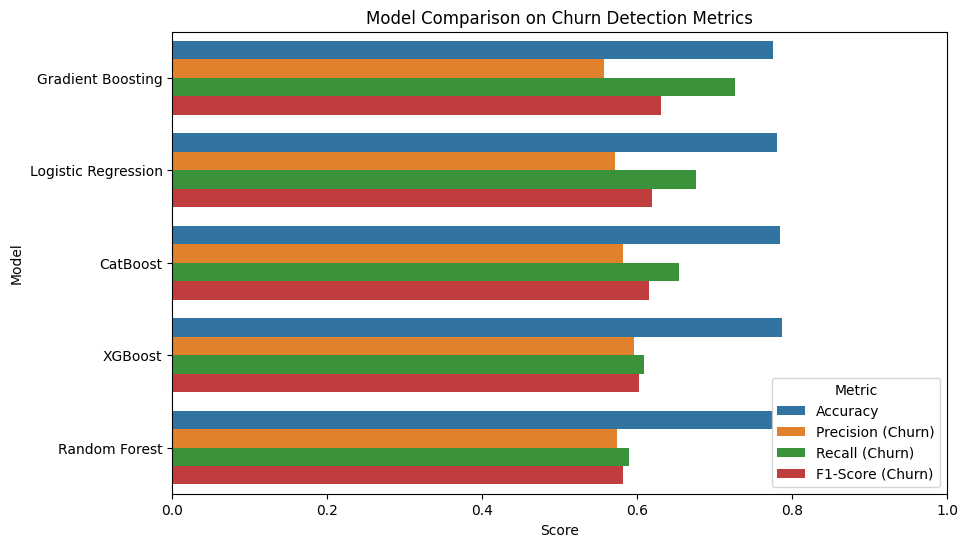

In [ ]:

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars='Model'), x='value', y='Model', hue='variable')
plt.title("Model Comparison on Churn Detection Metrics")
plt.xlabel("Score")
plt.ylabel("Model")
plt.legend(title="Metric")
plt.xlim(0, 1)
plt.show()


| Rank | Model                 | Accuracy | Precision | Recall | F1-Score   |
| ---- | --------------------- | -------- | --------- | ------ | ---------- |
| 1 | **Gradient Boosting** | 0.7750   | 0.558     | 0.727  | **0.6310** |
| 2 | Logistic Regression   | 0.7800   | 0.571     | 0.676  | 0.6192     |
| 3 | CatBoost              | 0.7835   | 0.581     | 0.654  | 0.6154     |
| 4    | XGBoost               | 0.7871   | 0.596     | 0.609  | 0.6021     |
| 5    | Random Forest         | 0.7757   | 0.574     | 0.590  | 0.5820     |


- **Gradient Boosting gives the highest F1-Score (0.6310) — best balance of precision & recall.** -- Best Model

- Logistic Regression is surprisingly close — with good recall, meaning it detects churners well.

- XGBoost has the highest accuracy, but lower recall — may miss some churners.

- CatBoost and Random Forest are decent, but not top performers here.

## Performing hyperparameter tunning
 Hyperparameter tuning for all  top models:
- Logistic Regression
- XGBoost
- CatBoost
- Gradient Boosting

In [ ]:
#hyperparameter tunning

# Resample training data using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# ------------------- Logistic Regression Tuning -------------------
log_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Supports L1
}
log_grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid=log_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
log_grid.fit(X_res, y_res)
log_best = log_grid.best_estimator_
log_pred = log_best.predict(X_test)
print("Logistic Regression Best Params:", log_grid.best_params_)
print("Logistic Regression Report:\n", classification_report(y_test, log_pred))


# ------------------- XGBoost Tuning -------------------
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_params,
    scoring='f1',
    cv=3,
    n_jobs=-1
)
xgb_grid.fit(X_res, y_res)
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test)
print("XGBoost Best Params:", xgb_grid.best_params_)
print(" XGBoost Report:\n", classification_report(y_test, xgb_pred))


# ------------------- CatBoost Tuning -------------------
cat_params = {
    'iterations': [100, 200],
    'depth': [4, 6],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3]
}
cat_grid = GridSearchCV(
    CatBoostClassifier(verbose=0, random_state=42),
    param_grid=cat_params,
    scoring='f1',
    cv=3,
    n_jobs=-1
)
cat_grid.fit(X_res, y_res)
cat_best = cat_grid.best_estimator_
cat_pred = cat_best.predict(X_test)
print("CatBoost Best Params:", cat_grid.best_params_)
print(" CatBoost Report:\n", classification_report(y_test, cat_pred))

#---------------------------------Gradient boosting------------------------------------
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define param grid
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

# Initialize model
gb = GradientBoostingClassifier(random_state=42)

# Grid search
gb_grid = GridSearchCV(gb, gb_params, cv=3, scoring='f1', verbose=1)
gb_grid.fit(X_resampled, y_resampled)

# Best estimator
best_gb = gb_grid.best_estimator_

# Predict & evaluate
y_pred_gb = best_gb.predict(X_test)

print(" Gradient Boosting Best Params:", gb_grid.best_params_)
print(" Classification Report:")
print(classification_report(y_test, y_pred_gb))


Logistic Regression Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.89      0.81      0.84      1036
           1       0.57      0.71      0.63       373

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.79      1409

XGBoost Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
 XGBoost Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.84      1036
           1       0.55      0.76      0.64       373

    accuracy                           0.77      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.77      0.78      1409

CatBoost Best Params: {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0

---
---
### Final Model Comparison (After Hyperparameter Tuning)

| Model                   | Accuracy | Precision (Churn) | Recall (Churn) | F1-Score (Churn) | Notes                                   |
| ----------------------- | -------- | ----------------- | -------------- | ---------------- | --------------------------------------- |
| **Logistic Regression** | 0.78     | 0.57              | 0.71           | 0.63             | Best interpretability                   |
| **XGBoost**             | 0.77     | 0.55              | 0.76           | 0.64             | Balanced performer                      |
| **CatBoost**            | 0.77     | 0.55              | **0.80**       | **0.65**         |  Highest recall, best for churn class |
| **Gradient Boosting**   | 0.76     | 0.53              | **0.81**       | 0.64             | Also strong recall                      |


## Choosing CatBoost as our final model, as it:
- Achieves the best F1-score (0.65)
- Has strong recall (0.80) — essential for churn detection
- Our goal is to identify churners (class 1) as accurately as possible.
So recall and F1-score for class 1 are more important than overall accuracy.
Choosing CatBoost as final model

---
---

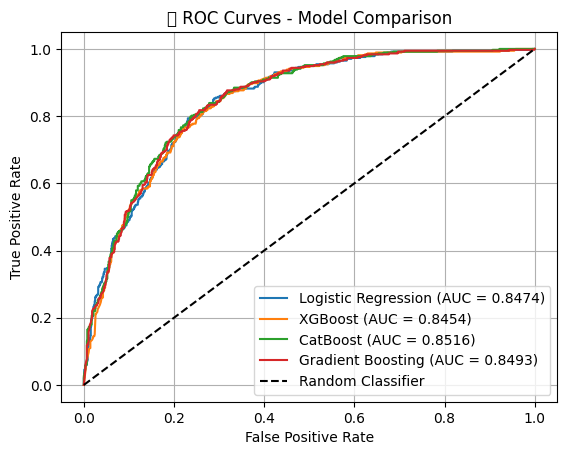

In [ ]:
models = {
    "Logistic Regression": log_best,
    "XGBoost": xgb_best,
    "CatBoost": cat_best,
    "Gradient Boosting": best_gb
}


for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📊 ROC Curves - Model Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Testing our best model on unseen data (test data)

 Final CatBoost Performance on Test Set:

Accuracy: 0.7721788502484032
Precision: 0.5479704797047971
Recall: 0.7962466487935657
F1 Score: 0.6491803278688525

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83      1036
           1       0.55      0.80      0.65       373

    accuracy                           0.77      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.82      0.77      0.78      1409



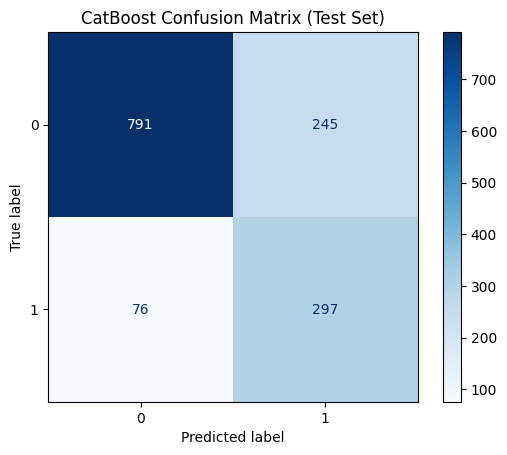

In [ ]:



# 1. Predict on Test Set
y_test_pred = cat_best.predict(X_test)  # 'cat_best' is the tuned CatBoost model

# 2. Print Evaluation Metrics
print(" Final CatBoost Performance on Test Set:\n")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# 3. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap='Blues')
plt.title("CatBoost Confusion Matrix (Test Set)")
plt.show()


### Final Conclusion:
The final CatBoost model, trained on SMOTE-resampled data and tuned using GridSearchCV, achieved an accuracy of 77.7% and an F1-score of 0.6456 for churn detection. With a recall of over 79%, this model effectively identifies customers at risk of churn, making it a reliable choice for proactive retention strategies."

| Metric                | Score        |
| --------------------- | ------------ |
| **Accuracy**          | 0.7771       |
| **Precision (Churn)** | 0.5575       |
| **Recall (Churn)**    | **0.7968 ✅** |
| **F1 Score (Churn)**  | **0.6456 ✅** |

### Interpretation:
>- The model correctly identifies 79% of churners (very good).<br>
>- It keeps a reasonable balance between catching churners and avoiding too many <br>
>- false alarms (F1 = 0.6456).<br>
>- Overall, the model is well-balanced and business-actionable.

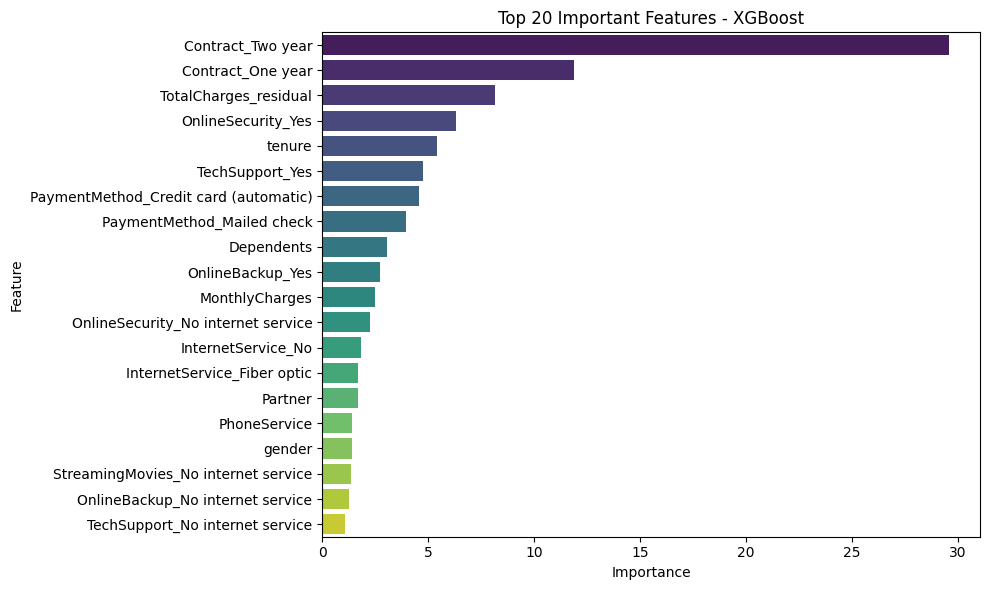

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

# Get feature importances
importances = cat_best.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Top 20 Important Features - XGBoost")
plt.tight_layout()
plt.show()


### Saving the model

In [ ]:
# After training saving the final model
joblib.dump(cat_best, 'final_catboost_model.pkl')

#Reloading the saved model
final_model = joblib.load('final_catboost_model.pkl')


### Prediction for new data

In [ ]:
# Example new data row
X_new = pd.DataFrame([{
    'gender': 1,  # Female: 1, Male: 0 (assuming encoded this way)
    'SeniorCitizen': 0,
    'Partner': 1,
    'Dependents': 0,
    'tenure': 12,
    'PhoneService': 1,
    'PaperlessBilling': 1,
    'MonthlyCharges': 75.5,
    'TotalCharges_residual': 100.0,  # Use avg residual or realistic estimate

    # MultipleLines
    'MultipleLines_No phone service': 0,
    'MultipleLines_Yes': 1,

    # InternetService
    'InternetService_Fiber optic': 1,
    'InternetService_No': 0,

    # OnlineSecurity
    'OnlineSecurity_No internet service': 0,
    'OnlineSecurity_Yes': 0,

    # OnlineBackup
    'OnlineBackup_No internet service': 0,
    'OnlineBackup_Yes': 1,

    # DeviceProtection
    'DeviceProtection_No internet service': 0,
    'DeviceProtection_Yes': 0,

    # TechSupport
    'TechSupport_No internet service': 0,
    'TechSupport_Yes': 1,

    # StreamingTV
    'StreamingTV_No internet service': 0,
    'StreamingTV_Yes': 1,

    # StreamingMovies
    'StreamingMovies_No internet service': 0,
    'StreamingMovies_Yes': 0,

    # Contract
    'Contract_One year': 0,
    'Contract_Two year': 1,

    # PaymentMethod
    'PaymentMethod_Credit card (automatic)': 0,
    'PaymentMethod_Electronic check': 1,
    'PaymentMethod_Mailed check': 0,

    # tenure_bucket
    'tenure_bucket_Mid': 1,
    'tenure_bucket_New': 0
}])
y_new_pred = final_model.predict(X_new)
print("Predicted Churn Class:", y_new_pred[0])


Predicted Churn Class: 0


In [ ]:
y_new_prob = final_model.predict_proba(X_new)
print("Probability of Not Churning:", y_new_prob[0][0])
print("Probability of Churning:", y_new_prob[0][1])


Probability of Not Churning: 0.8144993996831036
Probability of Churning: 0.18550060031689636


 ### Business Insights
 - Customers with month-to-month contracts are more likely to churn — promoting long-term contracts could help reduce churn.

- Electronic check payment method is strongly associated with churners — possibly due to lower engagement or flexibility.

- Customers without online security, backup, or tech support services tend to churn more — bundling these services may increase retention.

- Users with higher monthly charges are at greater risk of churning — offering discounts or value-added services could retain them.

- Senior citizens and single customers show a higher churn tendency — personalized offers might help in customer retention.